In [432]:
import os
import geopandas as gpd
import sys
sys.path.insert(0, os.path.join(os.path.expanduser("~"),"Desktop","projects", "GlacierView","src","common","modules"))
import read
import explore
import preprocess
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 
import importlib
importlib.reload(explore)

import pickle

### Data access workflow

Since the read.get_masks() API requires a single directory with unique images. We take the first image in each glacier's colleciton of images and copy to a new directory: "one_image"

In [453]:
folder_dir = "/Users/mattw/Desktop/projects/GlacierView/data/ee_data/training/UTM"
folders = next(os.walk(folder_dir))[1]
folders = sorted(folders)   

In [437]:
time_series_glacier_images = []
for folder in folders:
    glaciers_dir = os.path.join(folder_dir,folder)
    glacier_file_names = next(os.walk(glaciers_dir))[2]
    glacier_file_names = [glac for glac in glacier_file_names if len(glac) > 10] #ignores .DS store
    time_series_glacier_images.append(read.get_rasters(glaciers_dir,glacier_file_names))

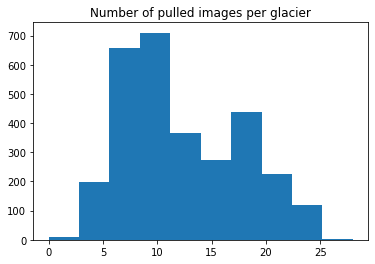

In [438]:
lengths = [len(glacier) for glacier in time_series_glacier_images]
plt.hist(lengths)
plt.title("Number of pulled images per glacier")
plt.show()

In [439]:
l5_band_dict = {
    'blue':0,
    'green':1,
    'red':2,
    'nir':3,
    'swir':4,
    'thermal':5,
    'swir2':6,
    'bqa':7
}
l7_band_dict = {
    'blue':0,
    'green':1,
    'red':2,
    'nir':3,
    'swir':4,
    'thermal_1':5,
    'thermal_2':6,
    'swir2':7,
    'panchromatic':8,
    'bqa':9
}
l8_band_dict = {
    'coastal_aerosol':0,
    'blue':1,
    'green':2,
    'red':3,
    'nir':4,
    'swir':5,
    'swir2':6,
    'panchromatic':7,
    'cirrus':8,
    'thermal_1':9,
    'thermal_2':10,
    'bqa':11
}

In [454]:
smooth_list = []
smoothed_glims_ids = []
for glacier_idx in range(len(folders)):
    if len(time_series_glacier_images[glacier_idx]) == 0:
        continue
    smoothed_glims_ids.append(folders[glacier_idx])
    n_bands, height, width = time_series_glacier_images[glacier_idx][0].shape
    resized = []
    for i in range(0,len(time_series_glacier_images[glacier_idx])):
        if n_bands == 8:
             time_series_glacier_images[glacier_idx][i] = time_series_glacier_images[glacier_idx][i][[
                                        l5_band_dict['red'],
                                        l5_band_dict['green'],
                                        l5_band_dict['blue'],
                                        l5_band_dict['nir'],
                                        l5_band_dict['swir'],
                                        l5_band_dict['thermal'],
                                        l5_band_dict['swir2'],
                                        ],:,:]

        if n_bands == 10:
            time_series_glacier_images[glacier_idx][i] = time_series_glacier_images[glacier_idx][i][[
                                        l7_band_dict['red'],
                                        l7_band_dict['green'],
                                        l7_band_dict['blue'],
                                        l7_band_dict['nir'],
                                        l7_band_dict['swir'],
                                        l7_band_dict['thermal_1'],
                                        l7_band_dict['swir2'],
                                        ],:,:]

        if n_bands == 12:
            time_series_glacier_images[glacier_idx][i] = time_series_glacier_images[glacier_idx][i][[
                                        l8_band_dict['red'],
                                        l8_band_dict['green'],
                                        l8_band_dict['blue'],
                                        l8_band_dict['nir'],
                                        l8_band_dict['swir'],
                                        l8_band_dict['thermal_1'],
                                        l8_band_dict['swir2'],
                                        ],:,:]


        tmp_resized = np.resize(time_series_glacier_images[glacier_idx][i],(7,height,width))
        tmp_zero_min = np.where(tmp_resized < 0, 0, tmp_resized)
        resized.append(tmp_zero_min)
    normalized = preprocess.normalize_list_of_numpy_arrays_to_unit_interval(resized)
    to_smooth = np.rollaxis(np.stack(normalized),1,4)
    smooth_list.append(to_smooth)
    

In [459]:
image_series = pd.Series(smooth_list, smoothed_glims_ids)

In [494]:
def get_stms(image):
    percentiles = [10,25,50,75,90]
    
    stms = []
    for percentile in percentiles:
        stms.append((str(percentile),np.percentile(image, percentile, axis = 0)))
    
    stms.append(("mean",np.mean(image, axis = 0)))
    return stms

In [495]:
random_int = np.where(image_series.index == "G080414E30321N")[0][0]

In [496]:
img = image_series.loc["G080414E30321N"]
stms = get_stms(img)

In [520]:
stms_flattened = []
methods = []
for method,stm in stms:
    methods.append(method)
    stms_flattened.append(stm.flatten())
    

In [523]:
X_train = pd.DataFrame(stms_flattened).transpose()
X_train.columns = methods 

In [524]:
X_train

,10,25,50,75,90,mean
0,0.000563,0.000906,0.001284,0.001999,0.002543,0.001418
1,0.000526,0.000808,0.001252,0.001896,0.002719,0.001375
2,0.000483,0.000763,0.001124,0.001443,0.001701,0.001106
3,0.000000,0.000399,0.001200,0.001928,0.002656,0.001237
4,0.000000,0.000413,0.000519,0.000591,0.000720,0.000510
...,...,...,...,...,...,...
181897,0.000504,0.000669,0.000857,0.001372,0.001931,0.001009
181898,0.000488,0.000747,0.000832,0.001696,0.002196,0.001155
181899,0.000000,0.000499,0.000771,0.000884,0.001118,0.000715
181900,0.000000,0.904709,0.919809,0.934418,0.959126,0.782135


In [479]:
def compare_percentiles(image_series, masks, image_num, band, percentiles = [10,30,50,70,80,90,100]):
    image = image_series[image_num]
    n_images = len(image)
    glims_id = image_series.index[image_num]
    img_list = []
    for percentile in percentiles:
        img_list.append((percentile,np.percentile(image, percentile, axis = 0)))
    img_list.append(("mean",np.mean(image, axis = 0)))

    ncols = 4
    nrows = int(np.ceil((len(percentiles)+1)/ncols))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,15))
    counter = 0
    print(glims_id)
    for i in range(nrows):
        for j in range(ncols):
            percentile,img = img_list[counter]
            if j == ncols-1:
                axes[i,j].imshow(masks[glims_id][:,:,0])

                
            else:
                axes[i,j].imshow(img[:,:,band])
                axes[i,j].title.set_text(f"GLIMS ID: {glims_id}\nPercentile: {percentile}\nBand: {band} Images: {n_images}")
            counter += 1
            if counter == len(percentiles):
                break
    
    plt.show()

G080414E30321N


IndexError: list index out of range

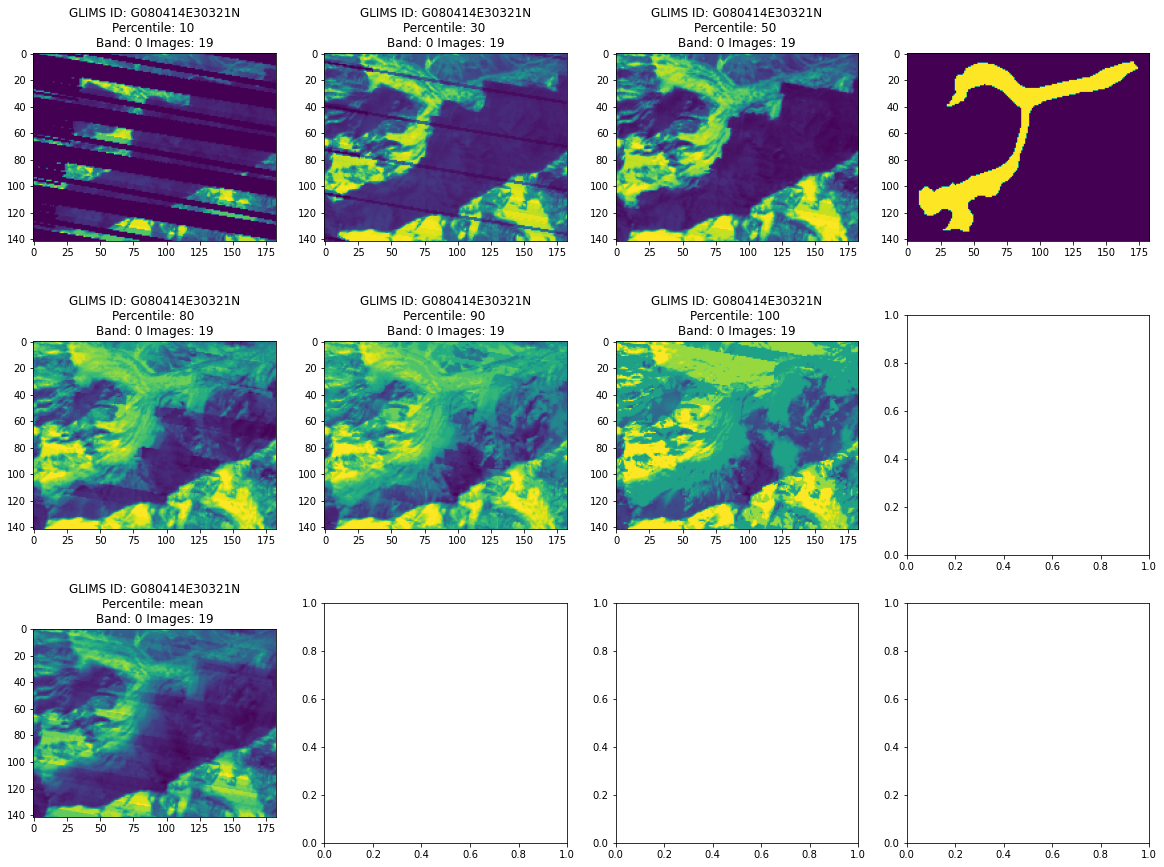

In [478]:
#random_int = random.randint(0,1)

compare_percentiles(image_series, masks, random_int, 0)

In [452]:
with open('/Users/mattw/Desktop/projects/GlacierView/data/smoothed_images/smoothed_images.pkl', 'wb') as handle:
    pickle.dump(image_series, handle)